<script type="text/x-mathjax-config">

MathJax.Hub.Config({

  tex2jax: {inlineMath: [['$','$'], ['\\(','\\)']]}

});

</script>

<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.5/latest.js?config=TeX-MML-AM_CHTML' async></script>

## Project4 서포트 벡터 머신 SVM

### 1. 개요

이번 프로젝트에서는 아달린이나 로지스틱 회귀와는 다른 방식으로 동작하지만 굉장히 강력한 성능을 자랑하는 이진 분류기 모델인 SVM(Support Vector Machine)을 구현하고자 한다. 그리고 SVM의 학습을 위해 이진 계획법(quadratic programming, QP)기법 중 하나인 SMO(Sequential Minimum Optimization) 알고리즘을 간단한 형태로 구현한다.

이 프로젝트는 다양한 문서들을 참고하여 만들어진 것임을 미리 명시한다. 참고문헌들은 문서 제일 하단에 소개되어 있으니 참고한다.

데이터의 분석과 시각화를 위해서 미리 정의해둔 플로팅 함수들을 사용한다. 해당 함수들은 projectfiles.analyzer.graphics에 정의되어있다.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from projectfiles.analyzer.graphics import plot_decision_regions, plot_data
from projectfiles.binclassifier import SVM, LogisticRegression

### 2. 로지스틱 회귀 모델의 한계

이진 분류 문제의 가장 근본적인 해결법은 두 클래스 레이블을 분류하는 어떠한 직선을 정의하는 것이다. 따라서 앞선 프로젝트에서 구현한 모든 이진 분류 모델들은 두 클래스 레이블을 구분하는 직선을 정의하며, 각 모델들은 가중치라는 하이퍼 파라미터를 통해 이 직선을 최적화한다. 문제는 이 모델들이 생성하는 직선이 항상 최적의 해가 아닐 수 있다는 것이다. 예를 들어 다음과 같은 데이터셋이 있다고 가정하자.

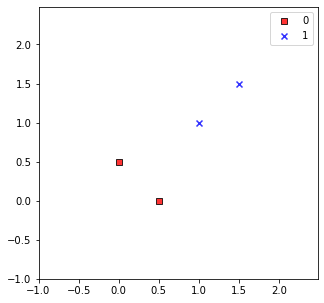

In [2]:
data = np.array([
    [0.5, 0],
    [0, 0.5],
    [1, 1],
    [1.5, 1.5]
])

label = np.array([0, 0, 1, 1])

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

plot_data(data, label, ax=ax)
ax.legend()

plt.show()

이 데이터셋을 구분하는 직선에는 여러가지가 있을 수 있다. 앞서 우리가 구현한 LogisticRegression 모델은 이러한 직선을 그린다.

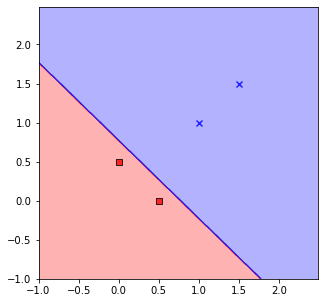

In [3]:
model = LogisticRegression(eta=0.1, n_iter=15, random_state=1)
model.fit(data, label, shuffle=True)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

plot_decision_regions(data, label, model, ax=ax)

plt.show()

LogisticRegression 모델이 훌륭하게 두 클래스 레이블을 구분하고 있음을 확인할 수 있다. 다만 이 직선이 제일 최선의 답이라고 할 수는 없다. 왜냐하면 직선이 음성 데이터들에 너무 가깝게 위치하고있기 때문이다. 보다 신뢰도 높은 결과를 위해서는 직선이 음성 데이터들과 양성 데이터들의 중간지점에 위치하는 것이 제일 좋으므로 위의 직선의 경우 최선의 답이라고 볼 수는 없다.

이런 경우 크게 두 가지의 해결책이 있다. 하나는 반복 횟수를 늘리는 것이고, 다른 하나는 학습률을 높이는 것이다. 다만 이것들이 근본적인 해결책이라고 볼 수는 없다. 왜냐하면 애초에 로지스틱 회귀 모델은 데이터에 대한 직선의 상대위치를 이용하여 학습하지 않기 때문이다. 물론 앞서 소개한 두 가지 해결책을 이용하면 보다 좋은 결과를 도출해낼 수는 있지만, 항상 최적의 결과만을 도출해낸다는 보장은 없다. 따라서 최적의 결졍 경계(decision boundary)를 찾기 위해서는 기존의 모델들과는 다른 형태의 새로운 모델이 필요하다.

### 3. 서포트 벡터 머신의 이론적 배경

SVM은 최적의 결정경계를 찾는 방식으로 동작하는 머신러닝 모델이다. 앞서 가장 최적의 결정 경계를 양성 데이터와 음성 데이터의 중간 지점에 위치하는 면으로 정의하였다. 이를 다음과 같이 일반화한다:

<blockquote>데이터들의 중간지점에 위치하면서 마진이 최대가 되는 결정 경계면을 최적해로 간주한다</blockquote>

그렇다면 어떻게 결정 경계면을 정의할 수 있을까? 고등 수학 과정에서 한번쯤은 보았을 직선의 방정식을 이용하면 쉽게 정의할 수 있다. 일반적으로 직선의 방정식은 다음과 같이 정의된다.

$$ax+b=0$$

이때 $a$를 $w$로 바꾸면 앞선 프로젝트에서 많이 봐왔던 익숙한 형태의 식이 나온다.

$$ w^Tx+b = 0$$

따라서 결정 경계를 정의하기 위해서는 $w$와 $b$만을 결정하면 된다. 이 두 하이퍼 파라미터를 SVM에서는 가중치 벡터(weight vector)와 문턱값(threshold value)라고 부른다. 앞선 프로젝트에서는 $weight$로 이 가중치 벡터를 표기하였으며, $weight[0]$는 문턱값으로 볼 수 있다. (사실 로지스텍 회귀에서 $weight[0]$는 편향(bias)이라고 부르기도 한다) SVM또한 다른 선형 이진 분류기와 마찬가지로 최대한 잘 데이터 샘플들을 분류하는 결정 경계를 찾기 위해 고안되었으며, 이러한 본질을 반드시 기억해야만 한다.

SVM이 클래스 레이블을 판별하는 방법은 다른 이진 분류기들과 크게 다르지 않다. 아래 그림은 임의의 결정경계에 따라 어떠한 데이터 $x$가 판별되는 것을 나타낸 그림이다. 결정 경계의 왼쪽에 위치한 데이터를 음성 데이터라 가정한다. 따라서 아래 그림에서 $x$는 음성 데이터이다.

<img src="images/graph1_support_vectors.jpg" width="400px">

이를 수학적으로 나타내기 위해서 결정 경계에 대한 법선 벡터 $w$를 도입한다. $w$는 결정 경계가 기울어진 정도를 정의하는 하이퍼 파라미터이므로 $x$를 $w$에 정사영하면 해당 데이터가 어느쪽에 위치하는지 쉽게 알 수 있다. 따라서 이를 이용하여 데이터 레이블에 대한 결정 기준을 아래와 같이 새롭게 정의한다.

$$
label=\left\{\begin{matrix}
1  & \text{if } w^{T}x+b>=0 \\ 
-1 & \text{otherwise}
\end{matrix}\right.
$$

이때 b는 문턱값(threshold value)으로 해당 결정 경계의 절편을 결정하는 하이퍼 파라미터이므로 위의 식은 아래와 같이 해석할 수 있다.

<blockquote>$x$를 $w$에 정사영한 것(내적)이 임의의 수 $-b$보다 크거나 같으면 양성 데이터로 분류하고, 그렇지 않은 경우 음성 데이터로 분류한다. </blockquote>

위 식은 앞선 프로젝트에서 확인했던 아달린의 레이블 결정 규칙과 크게 다르지 않다. 지금부터는 이 식에 마진에 대한 정보를 추가한다. 앞서 말했듯 최적의 결정 경계는 양성 데이터와 음성 데이터의 중간에 위치해야 한다. 따라서 위의 식에 양성 데이터의 마진과 음성 데이터의 마진이 항상 같아야 한다는 조건을 추가하면 다음과 같이 식이 변환된다.

$$
label=\left\{\begin{matrix}
1  & \text{if } w^{T}x+b \ge 1 \\ 
-1 & \text{if } w^{T}x+b \le -1
\end{matrix}\right.
$$

앞에서 소개한 식은 0을 기준으로 데이터를 구분하므로 마진에 대한 정보가 없다. 하지만 밑의 식에서는 양성 데이터와 결정 경계 사이의 거리(양성 데이터의 마진)가 음성 데이터와 결정 경계 사이의 거리(음성 데이터의 마진)와 같다는 정보가 추가되었다. 위 식에 따르면 $-1<w^{T}x+b<1$인 구간에는 그 어떠한 데이터도 없다는 것이 보장된다. 위의 두 식을 하나로 합치면 좀 더 쉬운 형태로 최적의 결정 경계에 대한 제약 조건을 규정할 수 있다.

$$y_{i}(w^{T}x_{i}+b) \ge 1 \; \ \ \ \ \ \ \ \ \text{for } i^\forall $$

여기서 $y_i$는 $i$번째 데이터의 클래스 레이블이고, $x_i$는 $i$번째 데이터를 의미한다. 최적의 결정 경계를 정의하는 두 하이퍼 파라미터 $w$와 $b$는 위의 제약 조건을 반드시 만족해야만 한다.

여기서 중요한 것은 마진은 크면 클 수록 좋다는 것이다. 마진이 크면 클 수록 결정 경계는 데이터에서 멀어질 것이므로 새로운 데이터들에 대한 정확도가 더 높을 것이다. 따라서 마진의 경계를 정의하는 $y_{i}(w^{T}x_{i}+b)=1$인 지점에 위치할 몇몇 데이터들을 결정하여 마진이 최대이면서 앞서 정의한 제약 조건을 만족하는 두 하이퍼 파라미터 $w$와 $b$를 찾는 것이 SVM을 구현하는데 있어 주요한 과제라 볼 수 있다.

마진의 경계를 결정하는 데이터 샘플들은 결정 경계에 가장 가까운 데이터들일 것이다. 나머지 데이터들의 분포와 평균과 같은 통계적인 특징들은 철저히 무시되며 SVM의 학습에 있어 크게 중요한 것은 아니다. 따라서 SVM을 학습하는 것의 의미는 사실상 마진의 경계에 위치할 데이터들을 찾는 과정으로 해석할 수 있다. 이처럼 마진의 경계에 위치하는 데이터들을 다른 데이터와 구분하기 위해 따로 서포트 벡터(support vector)라 명명한다. 이들은 앞서 말했듯 다음의 조건을 무조건 만족한다.

$$y_i(w^{T}x_i+b)=1$$

### 4. 라그랑주 승수법을 이용하여 문제 변환하기

앞서 우리는 최적의 결정 경계를 정의하기 위한 하이퍼 파라미터 $w$와 $b$를 정의하였고 이들이 따라야 하는 제약 조건을 부등식의 형태로 표현하였다. 이처럼 제약 조건이 부등식일 때 최적의 해를 찾는 문제는 라그랑주 승수(Lagrange Multipliers)를 이용하면 간단하게 풀 수 있다.

라그랑주 승수법을 적용하기에 앞서 먼저 최적화 해야하는 대상을 확인한다. 우리가 최적화 해야 하는 대상은 마진의 크기이다. 위의 제약 조건에서 우리는 이미 최적의 결정 경계가 따라야 하는 조건들을 규정하였다. 남은 것은 해당 제약 조건을 따르면서 가장 최대의 마진을 갖는 결정 경계를 정의하는 것이다.

따라서 먼저 마진의 크기가 어떻게 정의되는지를 살펴본다. 마진의 크기는 양성 데이터의 마진의 경계와 음성 데이터 마진의 경계 사이의 거리로 표현된다. 만약 양성 데이터 마진의 경계를 결정하는 데이터 샘플(양성 서포트 벡터)을 $x_{+}$라 하고, 음성 데이터 마진의 경계를 결정하는 데이터 샘플(음성 서포트 벡터)을 $x_{-}$라 하면, 마진의 크기는 다음과 같이 결정된다.

$$margin=\frac{||w^Tx_{+}-w^Tx_{-}||}{||w||}$$

그런데 서포트 벡터들은 다음의 두 식을 만족하므로,

$$\begin{aligned} w^{T}x_{+}+b=+1
\\ w^{T}x_{-}+b=-1 \end{aligned}$$

마진은 다음과 같이 정의된다.

$$margin=\frac{2}{||w||}$$

그런데 $\frac{2}{||w||}$를 최대화 하는 것 보다는 $\frac{||w||^2}{2}$를 최소화 하는 것이 더 간편하다. 왜냐하면 기본적으로 미분이 가능하고 미분했을 때 형태가 더 간단하기 때문이다. 따라서 최적화의 대상이 되는 목적 함수 $f$를 새롭게 정의하여 이를 최소화 하는 방식으로 계산한다. 목적 함수는 다음과 같다:

$$f(w)=\frac{||w||^2}{2}$$

여기서 라그랑주 승수법을 적용하기 위해 문제의 형태를 최종적으로 변환한다.

$$ \begin{aligned} & 
\min \frac{||w||^2}{2} \\ \\
\mbox{subject to : } \ & y_{i}(w^{T}x_{i}+b) \ge 1 \; \ \ \ \ \ \ \text{for } i^\forall
\end{aligned} $$

이제 제약 조건의 경계 함수와 목적 함수를 결합하여 라그랑지안(Lagrangian) 함수를 정의한다. 이때 $\alpha_i$는 라그랑주 승수로 제약 조건을 결합하는데 사용된다.

$$\mathcal{L}(w, b, \alpha_1, \alpha_2, ...)=\frac{||w||^2}{2}+\sum_{i}^{}\alpha_i(y_i(w^Tx_i+b)-1)$$

제약 조건이 부등식이므로 KKT조건을 도출한다. 이 경우 라그랑지안의 그레이디언트가 0이 되는 지점이 KKT 조건이 된다. 따라서, KKT 조건은 다음과 같다.

$$\begin{aligned}
&\triangledown \mathcal{L}_w=w-\sum_{i}^{}\alpha_iy_ix_i=0 & \ \ \ \ \ \ \ \ \ \ \ \text{condition 1: } & \text{stationarity} \\
&\triangledown \mathcal{L}_b=-\sum_{i}^{}\alpha_iy_i=0 & \ \ \ \ \ \ \ \ \ \ \ \text{condition 2: } & \text{stationarity} \\
&\triangledown \mathcal{L}_{\alpha_i}=y_i(w^Tx_i+b)-1=0 & \ \ \ \ \ \ \ \ \ \ \ \text{condition 3: } & \text{stationarity} 
\end{aligned}$$

또한 위의 문제에서 쌍대성을 적용하기 위해서는 라그랑주 승수가 항상 0 이상이어야 한다. 따라서 다음의 조건을 추가한다.

$$ \begin{aligned}
\alpha_i \ge 0 \; \ \ \ \ \ \ \text{for } i^\forall & \ \ \ \ \ \ \ \ \ \ \ \text{condition 4: } & \text{dual constraints}
\end{aligned}$$

재미있는 것은 KKT 조건 1과 2를 이용하면 라그랑지안을 다음과 같이 단변수 이차 함수의 형태로 변환할 수 있다는 점이다.

$$\begin{aligned}
\mathcal{L}(w, b, \alpha) &= \frac{||w||^2}{2} - \sum_{i}^{}\alpha_i(y_i(w^Tx+b)-1)
\\ &= \frac{||w||^2}{2} - \sum_{i}^{}\alpha_iy_iw^Tx_i + \sum_{i}^{}\alpha_i
\\ &= \frac{w^Tw}{2} - w^Tw + \sum_{i}^{}\alpha_i
\\ &= \sum_{i}^{}\alpha_i - \frac{1}{2}\sum_{i}^{}\sum_{j}^{}\alpha_i\alpha_jy_iy_jx_{i}^Tx_j = \mathcal{L}(\alpha) 
\end{aligned}$$

$\mathcal{L}(\alpha)$를 최적화하면 이때 최적의 $\alpha$를 얻을 수 있다. 구한 $\alpha$벡터를 KKT조건 1과 2에 대입하면 최적의 하이퍼 파라미터 $w$와 $b$를 구할 수 있으므로 전체적인 문제는 다음과 같이 변환된다.

<blockquote>마진을 최대화 하는 $\alpha$를 구한다</blockquote>

### 5. 이진 계획법으로 문제 해결하기

앞서 구한 $\mathcal{L}$을 살펴보면 형태가 이차식인 포물선 문제(convex problem)임을 알 수 있다. 따라서 쌍대 문제(dual problem)에 의해 다음과 같이 문제를 변환할 수 있다.

<blockquote>조건을 만족하는 $\alpha$에 대하여 라그랑지안을 최대로 하는 $\alpha$를 구한다</blockquote>

따라서 문제는 최종적으로 다음과 같이 나타난다.

$$\begin{aligned}
&\mathcal{L}(\alpha) = \sum_{i}^{}\alpha_i - \frac{1}{2}\sum_{i}^{}\sum_{j}^{}\alpha_i\alpha_jy_iy_jx_{i}^Tx_j &  \text{target function} \\
&\sum_{i}^{}\alpha_iy_i = 0 & \text{condition 1} \\
&\alpha_i \ge 0 \; \ \ \ \ \ \ \text{for } i^\forall & \text{condition 2}
\end{aligned}$$

여기서 이 문제를 풀기 위한 한 가지 해법 중 하나인 SMO(Sequential Minimal Optimization) 알고리즘을 소개한다. 이 알고리즘의 개요는 다음과 같다:

1. 임의의 두 $\alpha$값을 정한다.
2. 만약 두 값이 앞서 정의한 KKT 조건을 만족하지 않는다면 두 값을 갱신한다.
3. 모든 $\alpha$값이 KKT조건을 만족할 때까지 반복한다.

위 알고리즘에서 중요한 점은 임의의 두 $\alpha$값인 $\alpha_i$와 $\alpha_j$을 제외한 나머지 $\alpha$값을 상수로 취급한다는 것이다. 따라서 KKT 조건은 다음과 같이 변환된다. (단, $C$는 규제를 위해 도입된 파라미터이다) 

$$\begin{aligned}
& \alpha_iy_i+\alpha_jy_j=k & \text{condition 1}  \\
& 0 \le \alpha_i, \alpha_j \le C \; \ \ \ \ \ \ \text{for } i^\forall, j^\forall &  \text{condition 2}
\end{aligned}$$

최적화를 하는 메인 알고리즘은 아래 링크를 참고하여 구현하였다. 휴리스틱을 사용하지 않으면서 간단한 방법으로 SVM을 구현한 코드이니 참고할 것. 다만 이 코드를 그대로 붓꽃 데이터셋에 이용하면 연산이 제대로 수행되지 않을 수 있으니 데이터셋의 특성에 따라 일반화하는 작업이 반드시 필요하다. KKT 조건에 맞게 $\alpha$를 적절하게 갱신하는 방법에 초점을 맞추고 읽어볼 것. 이 코드를 개량한 버전이 projectfiles.binclassifier.SVM의 fit 메소드이니 참고할 것. 이 메소드의 구조는 링크에 있는 코드와 구조적으로 완벽하게 동일하다.

url: https://www.codeproject.com/Articles/1267445/An-Introduction-to-Support-Vector-Machine-SVM-and

위의 알고리즘으로 최적의 $\alpha$벡터를 찾았다면 남은 것은 $\alpha$벡터를 이용하여 실제 예측에 사용할 $w$와 $b$를 결정하는 것이다. 아래 수식에서 $*$는 벡터의 원소별 곱이고, $\cdot$은 내적 혹은 행렬곱을 의미한다. (아래 수식은 처음에 정의했던 KKT조건 $\text{condition 1}$, $\text{condition 3}$과 사실상 동일한 식이다)

$$\begin{aligned} w &= (\alpha * y) \cdot x \\ b &= \alpha \cdot y \end{aligned}$$

앞서 구현한 로지스틱 회귀와 아달린 모델과의 동일성을 해치지 않기 위해 $weight$를 다음과 같이 정의할 수도 있다.

$$weight[1:] = w \ ,\ \ weight[0] = b$$

이제는 아달린에서 사용했던 수식을 이용하여 클래스 레이블의 예측이 가능하다.

$$
\begin{aligned}
output = weight[1:]x+weight[0] \\ \\
label=\left\{\begin{matrix}
1  & \text{if } output>=0 \\ 
-1 & \text{otherwise}
\end{matrix}\right.
\end{aligned}
$$

### 6. SVM을 이용한 학습 예제

이전의 프로젝트에서 사용했던 데이터셋인 붓꽃 데이터셋을 이용하여 학습을 진행해보고자 한다.

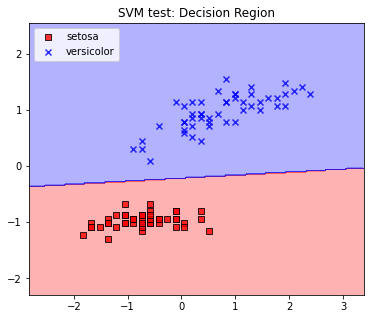

In [4]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)

# choosing only 'setosa' and 'versicolor'
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', 0, 1)  # labeling 'setosa' as 0 and 'versicolor' as 1
ynames = {0: 'setosa', 1: 'versicolor'}

# distract features of 'setosa' and 'versicolor'
X = df.iloc[0:100, [0, 2]].values

# standardization of the samples
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

# fitting model
# C       : regulation factor
# toler   : criteria to determine whether the alpha vector is changed
# max_iter: maximum iteration
model = SVM(random_state=1)
model.fit(X_std, y, C=0.6, toler=0.001, max_iter=40)

# plotting result
result = plt.figure(figsize=(6, 5))
ax = result.add_subplot()

plot_decision_regions(X_std, y, model, resolution=0.02, names=ynames, ax=ax)
ax.set_title('SVM test: Decision Region')
ax.legend(loc='upper left')

plt.show()

### 7. 선형 이진 분류기의 적용

이로써 선형 이진 분류기 모델 구현을 마무리한다. 선형 이진 분류기 모델은 데이터셋을 선형적인 결정 경계로 구분짓는 분류기 모델을 의미한다. 앞서 소개한 모든 이진 분류기 모델들은 전부 나름의 방식으로 션형 결정 경계를 생성하는 하이퍼 파라미터 $w$와 $b$(혹은 $weight$)를 생성하지만 각기 다른 특성을 갖는다. 따라서 절대적으로 어느 모델이 가장 뛰어나다고 말할 수는 없으며 데이터셋의 특성에 따라 적절한 형태의 모델을 적용하는 것이 중요하다.

아달린(혹은 퍼셉트론) 모델은 소개한 모든 모델들의 원형이 되었던 굉장히 중요한 의미를 갖는 모델이다. 아달린 모델은 인간의 뉴런이 학습하는 구조를 본떠서 만들어졌으며 뉴런이 학습하는 과정을 시뮬레이션하는 방식으로 작동한다. 이 모델은 자연스러운 방식으로 선형 결정 경계를 위한 하이퍼 파라미터 $w$와 $b$를 도출하며 뒤이어 등장하는 많은 분류기 모델들에 영감을 주었다.

로지스틱 회귀 모델은 아달린 모델에 확률적인 요소를 도입한 모델로 아달린 모델은 통계의 영역에서 해석할 수 있도록 한 모델이다. 이 모델은 단순히 결정 경계로 학습하는 것이 아닌 확률로 학습한다. 이를 위해 확률적 경사도와 같은 개념들이 추가되었고, 다양한 분야에서 활용되었다. 

SVM은 로지스틱 회귀 모델과는 다르게 순수하게 결정 경계를 결정하는 방식으로 동작한다. 따라서 선형적으로 완전하게 구분될 수 있는 데이터셋에 한해 가장 최적의 하이퍼 파라미터 $w$와 $b$를 도출할 것이라는 것이 보장된다. 이것이 로지스틱 회귀 모델과의 가장 큰 차이점이다. 로지스틱 회귀 모델은 확률적으로 결정 경계를 정의하기 때문에 로지스틱 회귀 모델이 생성하는 결정 경계가 반드시 최적의 결정 경계일 것이라는 보장이 없다. 반대로 SVM은 최적의 결정 경계가 생성될 것임을 기대할 수 있지만 확률적으로 해석하기 힘들다.

SVM은 가장 최근에 고안된 모델인 만큼 다양한 분야에서 많이 활용되었다. 그만큼 실용성이 높은 모델이지만 온라인 알고리즘으로 확장하는 것이 힘들다는 단점이 있다는 것 또한 생각해야 한다. 따라서 학습에 필요한 데이터셋이 실시간으로 센서에 의해 수집되고, 그 데이터를 실시간으로 학습하는 경우, SVM을 사용하는 것은 다소 어려울 수 있다.

하지만 로지스틱 회귀는 온라인 알고리즘으로 쉽게 변환할 수 있다. 다만 로지스틱 회귀는 철저히 선형 결정 경계만을 생성할 수 있다는 점에 유의해야 한다. SVM은 슬랙 변수나 커널 트릭과 같은 다양한 방법들을 통해 비선형적 결정 경계를 생성할 수 있다. 물론 로지스틱 회귀 모델이 비선형적 결정 경계를 아예 만들 수 없는 것은 아니다. 최근들어 떠오르고 있는 딥러닝 기술은 사실상 로지스틱 회귀 모델이 직렬로 연결된 형태가 그 시초이며, 이렇게 만들어진 딥러닝 모델은 어떠한 형태의 비선형적 결정 경계도 생성할 수 있다.

따라서 어떠한 모델을 어떻게 데이터셋에 적용할지를 결정하는 것은 굉장히 중요한 문제이며, 모델의 내부 알고리즘을 구현하는 것 보다 어쩌면 이진 분류라는 문제를 푸는 데에 있어 더 중요한 요소일 수 있다는 점을 강조한다.

### 참고문헌


#### 서포트 벡터 머신
1. MIT OCW: MIT 6.034 Artificial Intelligence, 2010 fall <a href="https://www.youtube.com/watch?v=_PwhiWxHK8o">링크</a>
2. Jaejun Yoo's Playground <a href="http://jaejunyoo.blogspot.com/2018/01/support-vector-machine-1.html">링크</a>

#### 라그랑주 승수법
1. 위키피디아 라그랑주 승수법 <a href="https://ko.wikipedia.org/wiki/%EB%9D%BC%EA%B7%B8%EB%9E%91%EC%A3%BC_%EC%8A%B9%EC%88%98%EB%B2%95">링크</a>
2. Deep Campus <a href="https://pasus.tistory.com/73">링크</a>

#### SMO
1. 위키피디아 SMO <a href="https://en.wikipedia.org/wiki/Sequential_minimal_optimization">링크</a>
2. An Introduction to Support Vector Machine (SVM) and the Simplified SMO Algorithm <a href="https://www.codeproject.com/Articles/1267445/An-Introduction-to-Support-Vector-Machine-SVM-and">링크</a>